In [1]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/imdb_labelled.txt

--2022-04-08 09:50:35--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/imdb_labelled.txt
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.143.30
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.143.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85285 (83K) [text/plain]
Saving to: ‘imdb_labelled.txt’

imdb_labelled.txt   100%[===================>]  83.29K   429KB/s    in 0.2s    

2022-04-08 09:50:35 (429 KB/s) - ‘imdb_labelled.txt’ saved [85285/85285]



In [2]:
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
imdb_ds = pd.read_csv('imdb_labelled.txt', sep ='\t', header = None, names = ['reviews', 'sentiment'])
imdb_ds

,reviews,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
743,I just got bored watching Jessice Lange take h...,0
744,"Unfortunately, any virtue in this film's produ...",0
745,"In a word, it is embarrassing.",0
746,Exceptionally bad!,0


In [5]:
imdb_ds['reviews'].to_list()

['A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  ',
 'Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  ',
 'Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.  ',
 'Very little music or anything to speak of.  ',
 'The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.  ',
 "The rest of the movie lacks art, charm, meaning... If it's about emptiness, it works I guess because it's empty.  ",
 'Wasted two hours.  ',
 'Saw the movie today and thought it was a good effort, good messages for kids.  ',
 'A bit predictable.  ',
 'Loved the casting of Jimmy Buffet as the science teacher.  ',
 'And those baby owls were adorable.  ',
 "The movie showed a lot of Florida at it's best, made it look very appealing.  ",
 'The Son

In [6]:
imdb_ds['reviews'].isnull().sum()

0

#Data Cleaning

In [7]:
import re

def clean_special_patterns(text):
    """Remove special patterns - email, url, date etc."""
    html_regex = re.compile(r"<.*?>")
    email_regex = re.compile(r"[\w.-]+@[\w.-]+")
    url_regex = re.compile(r"(http|www)[^\s]+")
    date_regex = re.compile(r"[\d]{2,4}[ -/:]*[\d]{2,4}([ -/:]*[\d]{2,4})?") # a way to match date
    new_line = re.compile(r"/(\r\n)+|\r+|\n+|\t+/")
    number = re.compile(r"[\d+]")
    under = re.compile(r"[^a-zA-Z0-9:$-,%.?!]+")
    simbols = re.compile(r"[^\w\s/'/`]")
    spaces = re.compile(r"\s{2,}")
    remove_singlelett= re.compile(r"(^| ).( |$)")

    ## remove
    text = text.lower()
    text = number.sub(" ", text)
    text = html_regex.sub(" ", text)
    text = url_regex.sub(" ", text)
    text = email_regex.sub(" ", text)
    text = date_regex.sub(" ", text)
    text = new_line.sub(" ", text)
    text = under.sub(" ", text)
    text = simbols.sub(" ", text)
    text = spaces.sub(" ", text)
    text = text.replace("`", "'")
    text = remove_singlelett.sub("",text)
    return text

#Cleaning AllinOne

In [8]:
#Applichiamo la funzione di cleaning all in once
imdb_ds['reviews'] = imdb_ds['reviews'].apply(clean_special_patterns)
imdb_ds

,reviews,sentiment
0,very very very slow moving aimless movie about...,0
1,not sure who was more lost the flat characters...,0
2,attempting artiness with black white and cleve...,0
3,very little music or anything to speak of,0
4,the best scene in the movie was when gerardo i...,1
...,...,...
743,just got bored watching jessice lange take her...,0
744,unfortunately any virtue in this film's produc...,0
745,inword it is embarrassing,0
746,exceptionally bad,0


In [9]:
imdb_ds['reviews'] = imdb_ds['reviews'].replace({'negative':0,'positive':1})
imdb_ds = imdb_ds[['reviews','sentiment']]
imdb_ds

,reviews,sentiment
0,very very very slow moving aimless movie about...,0
1,not sure who was more lost the flat characters...,0
2,attempting artiness with black white and cleve...,0
3,very little music or anything to speak of,0
4,the best scene in the movie was when gerardo i...,1
...,...,...
743,just got bored watching jessice lange take her...,0
744,unfortunately any virtue in this film's produc...,0
745,inword it is embarrassing,0
746,exceptionally bad,0


#STOPWORDS + LEMMATIZATION Function with SpaCy

In [10]:
## Spacy Custom Pipeline
import numpy as np
import multiprocessing as mp

import string
import spacy 
from sklearn.base import TransformerMixin, BaseEstimator


nlp = spacy.load("en_core_web_sm")

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 nlp = nlp,
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Punctuation removal
            2. Stop words removal
            3. Lemmatization

        nlp  - spacy model
        n_jobs - parallel jobs to run
        """
        self.nlp = nlp
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _remove_punct(self, doc):
        return (t for t in doc if t.text not in string.punctuation)

    def _remove_stop_words(self, doc):
        return (t for t in doc if not t.is_stop)

    def _lemmatize(self, doc):
        return ' '.join(t.lemma_ for t in doc)

    def _preprocess_text(self, text):
        doc = self.nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

In [11]:
#takes 2 min of processing
text_preprocess = TextPreprocessor(n_jobs=-1)._preprocess_text
#df["text"][0:10].apply(text_preprocess)
imdb_ds['reviews'] = imdb_ds['reviews'].apply(text_preprocess)
imdb_ds

,reviews,sentiment
0,slow move aimless movie aboutdistresse drift y...,0
1,sure lose flat character audience nearly half ...,0
2,attempt artiness black white clever camera ang...,0
3,little music speak,0
4,good scene movie gerardo try findsong keep run...,1
...,...,...
743,get bore watch jessice lange clothe,0
744,unfortunately virtue film production work lose...,0
745,inword embarrassing,0
746,exceptionally bad,0


#EDA

In [12]:
cleaned = ' '.join(imdb_ds['reviews'].to_list())

(-0.5, 799.5, 399.5, -0.5)

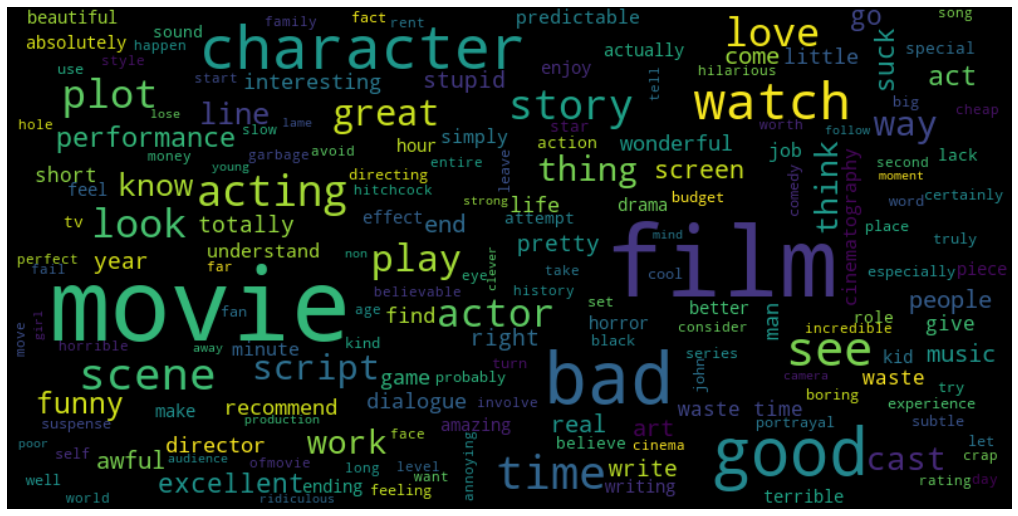

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                      max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 667)

wordcloud.generate(cleaned)

plt.figure(figsize=(18,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

#Bag of Words

In [14]:
X = imdb_ds['reviews'] # FEATURES
y = imdb_ds['sentiment'] # TARGET

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)

X_ = vectorizer.fit_transform(X).toarray()
X_

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer()
X_ = tfidfconverter.fit_transform(X_).toarray()
X_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.50507356],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.25481562, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

In [18]:
labels = ['Negative', 'Positive']

##RandomForest

In [19]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=1000, random_state=667,max_depth=5)
classifier.fit(X_train, y_train) 

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=667)

In [20]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.6844919786096256


Text(69.0, 0.5, 'Actual')

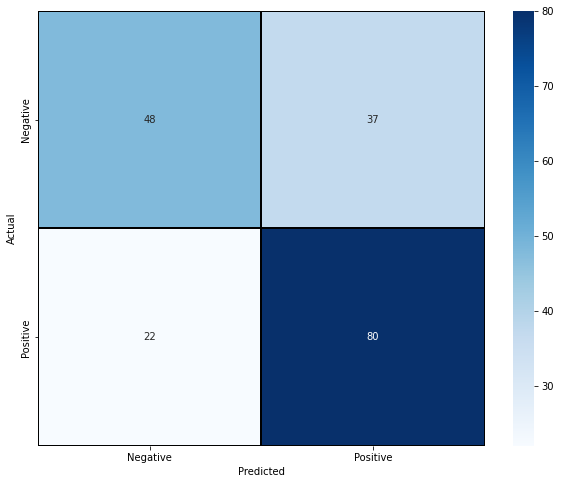

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [22]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.69      0.56      0.62        85
    Positive       0.68      0.78      0.73       102

    accuracy                           0.68       187
   macro avg       0.68      0.67      0.67       187
weighted avg       0.68      0.68      0.68       187



In [23]:
!pip install plot-metric --quiet

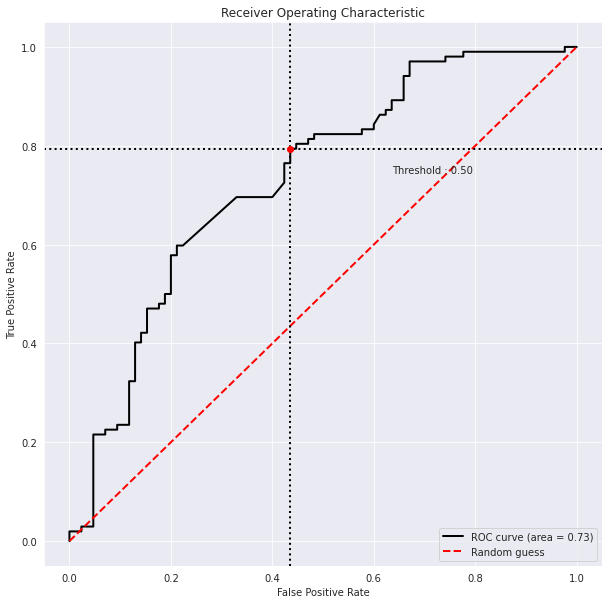

In [24]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

##MultinomialNB

In [25]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train) 

MultinomialNB()

In [26]:
# accuracy score on the test data
y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.7165775401069518


Text(69.0, 0.5, 'Actual')

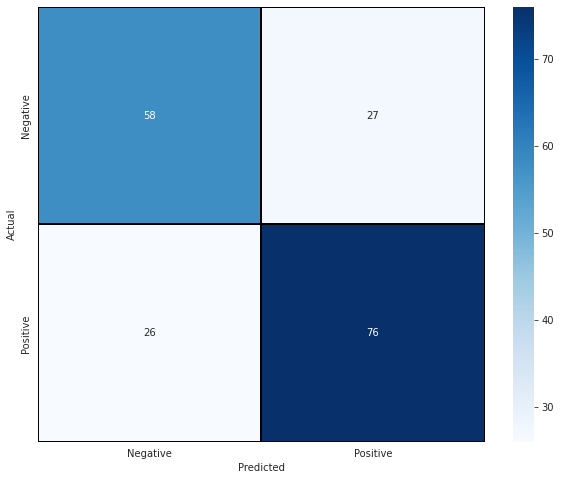

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [28]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.69      0.68      0.69        85
    Positive       0.74      0.75      0.74       102

    accuracy                           0.72       187
   macro avg       0.71      0.71      0.71       187
weighted avg       0.72      0.72      0.72       187



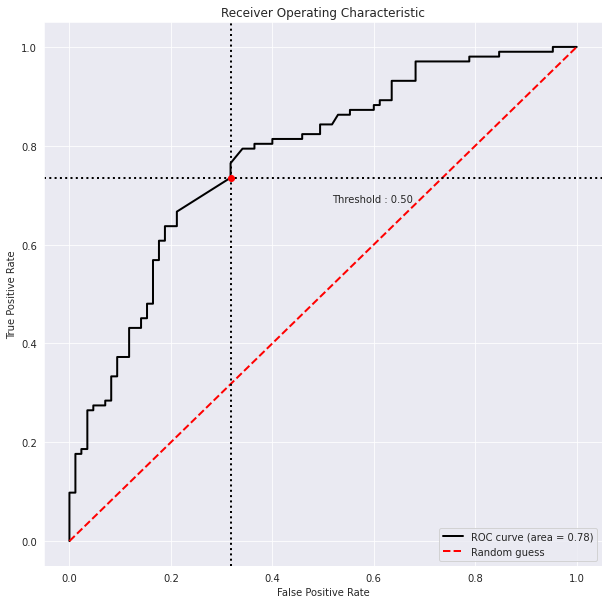

In [29]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

##SGD Classifier

In [30]:
# accuracy score on the test data
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=667, max_iter=5, tol=None)
classifier.fit(X_train, y_train) 

y_pred = classifier.predict(X_test)
test_data_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.6737967914438503


Text(69.0, 0.5, 'Actual')

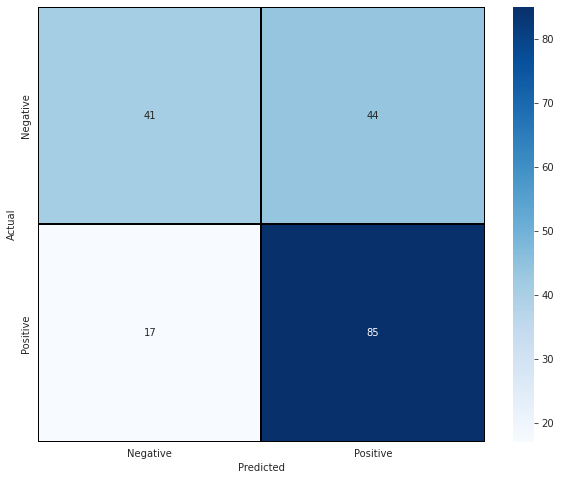

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = labels, 
            yticklabels = labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

In [32]:
from sklearn.metrics import classification_report
#labels = ['class1', 'class2']
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.71      0.48      0.57        85
    Positive       0.66      0.83      0.74       102

    accuracy                           0.67       187
   macro avg       0.68      0.66      0.65       187
weighted avg       0.68      0.67      0.66       187



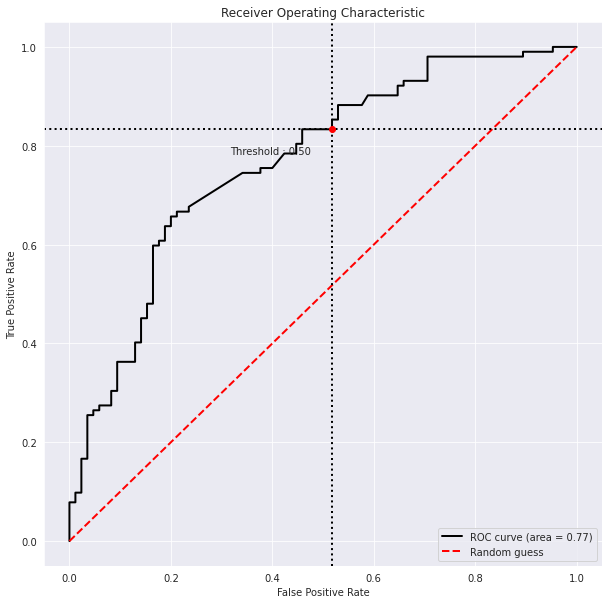

In [33]:
from plot_metric.functions import BinaryClassification
y_pred_proba = classifier.predict_proba(X_test)[::,1]

#labels = ['class1', 'class2']
bc = BinaryClassification(y_test, y_pred_proba, labels=labels)

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve();

#Pipeline

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, 
                                                    random_state=667
                                                    )

RICORDA: il classifier va cambiato a seconda di quale ha il risultato migliore!!!!

In [36]:
from sklearn.pipeline import Pipeline

text_preprocess = TextPreprocessor(n_jobs=-1)
bow = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
tfidf = TfidfTransformer()
classifier = MultinomialNB()

pipe = Pipeline([
                ('lemma_stop_rem',text_preprocess),
                ('bow',bow),
                ('tfidf',tfidf),
                ('clf',classifier),
                ])

pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)
test_data_accuracy = accuracy_score(y_test, predicted)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.6524064171122995


In [37]:
test = pd.Series({'text':"I love you"})

In [38]:
prediction = pipe.predict(test)
print(prediction[0])

if (prediction[0] == 0):
  print('Negative')
else:
  print('Positive')

1
Positive


In [39]:
import joblib

joblib.dump(pipe,'pipeline_classifier_SpaCy.pkl')

['pipeline_classifier_SpaCy.pkl']